In [1]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as pb
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [2]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [3]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = pb.connect(pb.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = pb.loadURDF("plane.urdf")


# Load the URDF of the robot
scara = pb.loadURDF("scara_robot_left.urdf")

In [4]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
pb.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
pb.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [5]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
pb.setJointMotorControl2(scara, 1, pb.VELOCITY_CONTROL, force=0)
pb.setJointMotorControl2(scara, 2, pb.VELOCITY_CONTROL, force=0)

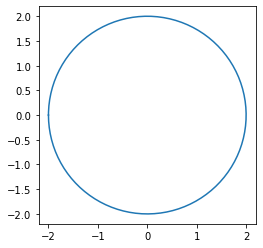

In [6]:
npoints=200
theta = np.linspace( -np.pi,np.pi, npoints)

# the radius of the circle
r = 2

# compute x1 and x2
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

# create the figure
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.set_aspect(1)
plt.show()

In [7]:
# x=np.array([])
# y=np.array([])
# x=np.append(x,np.array([1]*50))
# y=np.append(y,np.linspace(0,1,50))
# x= np.append(x,np.linspace(1,-1,100))
# y=np.append(y,np.array([1]*100))
# x=np.append(x,np.array([-1]*100))
# y=np.append(y,np.linspace(1,-1,100))
# x=np.append(x,np.linspace(-1,1,100))
# y=np.append(y,np.array([-1]*100))
# x=np.append(x,np.array([1]*50))
# y=np.append(y,np.linspace(-1,0,50))

# plt.figure()
# plt.scatter(x,y,s=1,alpha=0.5)

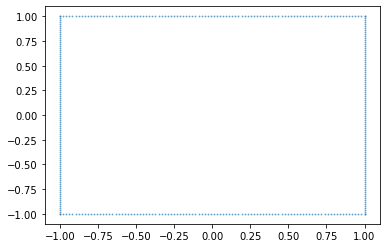

In [8]:
x=np.array([])
y=np.array([])
x=np.append(x,np.array([-1]*100))
y=np.append(y,np.linspace(-1,1,100))
x= np.append(x,np.linspace(-1,1,100))
y=np.append(y,np.array([1]*100))
x=np.append(x,np.array([1]*100))
y=np.append(y,np.linspace(1,-1,100))
x=np.append(x,np.linspace(1,-1,100))
y=np.append(y,np.array([-1]*100))

plt.figure()
plt.scatter(x,y,s=1,alpha=0.5)

In [9]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory1(t):
    theta = np.linspace(0,2*np.pi, npoints)

    # the radius of the circle
    r = t

    # compute x1 and x2
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    for i in range(npoints):
        for j in range(1):
            control(np.array([x1[i],x2[i]]))
    

    
    
    



In [10]:
def trajectory2():
    for i in range(400):
        control(np.array([x[i],y[i]]))

In [11]:
pos_actual=[]

In [12]:
##########################################
# Control loop to follow the trajectory
##########################################
# Kinematics for serial-2R
def control(numpy_array):
    pt_des = numpy_array # or p2

    valid, [theta1, theta2] = inverse_kinematics(pt_des[0], pt_des[1], 1, 1)
    if valid==False:
        return
    
    
    dt     = 0.0001 # simulation time-step
    p_gain = 2000 # Proportional gain
    d_gain = 10 # Derivative gain
    error  = 0
    error_old = 0
    desired_pos = np.array([theta1, theta2])
    for _ in range(1000):
        pos1, _, _, _ = pb.getJointState(scara,1)
        pos2, _, _, _ = pb.getJointState(scara,2)
        pos = np.array([pos1, pos2])
        error_old = error
        error = desired_pos - pos
        error_d = (error - error_old)/dt
        control_force = p_gain * error + d_gain * error_d
        control_force = np.clip(control_force, -500, 500)
        pb.setJointMotorControlArray(scara, [1,2], pb.TORQUE_CONTROL, forces=control_force)
        pb.stepSimulation()


    # Check if the robot has reached the desired position
    pos1, _, _, _ = pb.getJointState(scara, 1)
    pos2, _, _, _ = pb.getJointState(scara, 2)
    pt_act = forward_kinematics(pos1, pos2, 1, 1)
    pos_actual.append(pt_act)
    print(pt_des)
    print(pt_act)





In [13]:
trajectory2()

[-1. -1.]
[-0.9999999946173722, -0.9999999955908122]
[-1.         -0.97979798]
[-1.0000000000046858, -0.9797979798186659]
[-1.         -0.95959596]
[-1.0000000000042881, -0.9595959596166234]
[-1.         -0.93939394]
[-1.0000000000038953, -0.9393939394145826]
[-1.         -0.91919192]
[-1.000000000003507, -0.9191919192125443]
[-1.        -0.8989899]
[-1.0000000000031206, -0.8989898990105093]
[-1.         -0.87878788]
[-1.000000000002737, -0.8787878788084755]
[-1.         -0.85858586]
[-1.0000000000023566, -0.8585858586064452]
[-1.         -0.83838384]
[-1.0000000000019766, -0.8383838384044185]
[-1.         -0.81818182]
[-1.0000000000015985, -0.8181818182023952]
[-1.        -0.7979798]
[-1.0000000000012217, -0.7979797980003752]
[-1.         -0.77777778]
[-1.0000000000008458, -0.7777777777983604]
[-1.         -0.75757576]
[-1.0000000000004683, -0.7575757575963495]
[-1.         -0.73737374]
[-1.0000000000000933, -0.737373737394343]
[-1.         -0.71717172]
[-0.9999999999997167, -0.717171

[-0.57575758  1.        ]
[-0.5757575757785096, 0.9999999999970552]
[-0.55555556  1.        ]
[-0.5555555555765633, 0.9999999999966701]
[-0.53535354  1.        ]
[-0.5353535353746262, 0.9999999999962824]
[-0.51515152  1.        ]
[-0.5151515151726975, 0.999999999995894]
[-0.49494949  1.        ]
[-0.49494949497077867, 0.9999999999955038]
[-0.47474747  1.        ]
[-0.4747474747688697, 0.9999999999951126]
[-0.45454545  1.        ]
[-0.4545454545669714, 0.9999999999947199]
[-0.43434343  1.        ]
[-0.43434343436508394, 0.9999999999943265]
[-0.41414141  1.        ]
[-0.41414141416320827, 0.9999999999939313]
[-0.39393939  1.        ]
[-0.39393939396134403, 0.9999999999935368]
[-0.37373737  1.        ]
[-0.3737373737594921, 0.999999999993141]
[-0.35353535  1.        ]
[-0.35353535355765275, 0.9999999999927465]
[-0.33333333  1.        ]
[-0.33333333335582704, 0.9999999999923516]
[-0.31313131  1.        ]
[-0.3131313131540143, 0.9999999999919574]
[-0.29292929  1.        ]
[-0.29292929295221

[1.         0.05050505]
[0.9999999999995732, 0.05050505052571841]
[1.         0.03030303]
[0.9999999999999921, 0.030303030323429625]
[1.         0.01010101]
[1.0000000000004, 0.010101010121118748]
[ 1.         -0.01010101]
[1.0000000000007954, -0.010101010081213446]
[ 1.         -0.03030303]
[1.0000000000011768, -0.030303030283566956]
[ 1.         -0.05050505]
[1.0000000000015432, -0.050505050485941116]
[ 1.         -0.07070707]
[1.0000000000018936, -0.0707070706883357]
[ 1.         -0.09090909]
[1.0000000000022267, -0.09090909089075061]
[ 1.         -0.11111111]
[1.000000000002541, -0.11111111109318395]
[ 1.         -0.13131313]
[1.000000000002836, -0.13131313129563682]
[ 1.         -0.15151515]
[1.0000000000031097, -0.15151515149810602]
[ 1.         -0.17171717]
[1.0000000000038993, -0.1717171717010304]
[ 1.         -0.19191919]
[1.0000000000052183, -0.1919191919044796]
[ 1.         -0.21212121]
[1.000000000006465, -0.21212121210798363]
[ 1.         -0.23232323]
[1.0000000000072107, 

[-0.39393939 -1.        ]
[-0.39393939392665367, -1.0000000000029503]
[-0.41414141 -1.        ]
[-0.41414141412854655, -1.0000000000024591]
[-0.43434343 -1.        ]
[-0.43434343433042943, -1.0000000000019782]
[-0.45454545 -1.        ]
[-0.454545454532304, -1.0000000000015077]
[-0.47474747 -1.        ]
[-0.47474747473417034, -1.0000000000010485]
[-0.49494949 -1.        ]
[-0.4949494949360287, -1.0000000000005995]
[-0.51515152 -1.        ]
[-0.5151515151378807, -1.0000000000001614]
[-0.53535354 -1.        ]
[-0.5353535353397255, -0.9999999999997337]
[-0.55555556 -1.        ]
[-0.5555555555415634, -0.9999999999993173]
[-0.57575758 -1.        ]
[-0.575757575743395, -0.999999999998912]
[-0.5959596 -1.       ]
[-0.5959595959452217, -0.9999999999985176]
[-0.61616162 -1.        ]
[-0.6161616161470421, -0.9999999999981337]
[-0.63636364 -1.        ]
[-0.6363636363488572, -0.9999999999977617]
[-0.65656566 -1.        ]
[-0.6565656565506663, -0.9999999999974001]
[-0.67676768 -1.        ]
[-0.67676

In [14]:
pb.disconnect()

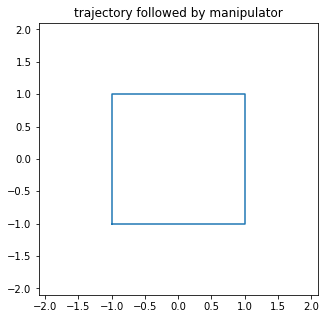

In [15]:
pos_actual=np.array(pos_actual)
plt.figure(figsize=(5,5))
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.title('trajectory followed by manipulator')
plt.plot(pos_actual[:,0],pos_actual[:,1])
#plt.plot(x1,x2)

In [16]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = pb.connect(pb.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = pb.loadURDF("plane.urdf")


# Load the URDF of the robot
scara = pb.loadURDF("scara_robot_left.urdf")

In [17]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
pb.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
pb.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [18]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
pb.setJointMotorControl2(scara, 1, pb.VELOCITY_CONTROL, force=0)
pb.setJointMotorControl2(scara, 2, pb.VELOCITY_CONTROL, force=0)

In [19]:
pos_actual=[]
trajectory1(2)

[2. 0.]
[2.0, 0.0]
[1.99900318 0.0631371 ]
[1.99900317825454, 0.06313709946019877]
[1.99601371 0.12621126]
[1.99601370666737, 0.12621126255602888]
[1.99103457 0.18915962]
[1.991034565208781, 0.1891596155205444]
[1.98407072 0.25191941]
[1.9840707171952643, 0.2519194100665314]
[1.9751291  0.31442809]
[1.975129104341967, 0.3144280858659084]
[1.96421864 0.37662333]
[1.9642186398430401, 0.37662333291122146]
[1.9513502  0.43844315]
[1.9513501994867737, 0.4384431536276153]
[1.93653661 0.49982592]
[1.9365366108143727, 0.49982592467336384]
[1.91979264 0.56071046]
[1.9197926403331866, 0.5607104583673574]
[1.90113498 0.62103606]
[1.9011349787971334, 0.6210360636823142]
[1.88058222 0.68074261]
[1.8805822245689923, 0.6807426067429159]
[1.85815487 0.73977057]
[1.8581548650811521, 0.7397705707685628]
[1.83387526 0.79806112]
[1.833875256413293, 0.7980611154009943]
[1.8077676  0.85555614]
[1.8077676010073591, 0.8555561353576382]
[1.77985792 0.91219832]
[1.7798579235420398, 0.9121983183522202]
[1.750174

[-1.33982473 -1.48488036]
[-1.3398247314872778, -1.4848803618120363]
[-1.29228143 -1.52643661]
[-1.292281428675431, -1.5264366050054576]
[-1.24344995 -1.56647126]
[-1.2434499516313915, -1.5664712629945976]
[-1.19337898 -1.60494443]
[-1.1933789766334486, -1.604944428361712]
[-1.14211842 -1.64181775]
[-1.1421184155184076, -1.641817750218861]
[-1.08971937 -1.67705447]
[-1.0897193659283821, -1.6770544724369105]
[-1.03623406 -1.71061947]
[-1.0362340603755626, -1.7106194702848367]
[-0.98171581 -1.74247929]
[-0.981715814175701, -1.7424792854428257]
[-0.92621897 -1.77260216]
[-0.9262189723022547, -1.7726021593542516]
[-0.86979886 -1.80095806]
[-0.8697988552141308, -1.8009580648832964]
[-0.8125117  -1.82751874]
[-0.812511703711045, -1.827518736246656]
[-0.75441462 -1.8522577 ]
[-0.7544146228714791, -1.8522576971894824]
[-0.69556553 -1.87515029]
[-0.6955655251290856, -1.8751502873774943]
[-0.63602307 -1.89617369]
[-0.6360230725443274, -1.8961736869789312]
[-0.57584662 -1.91530694]
[-0.5758466183

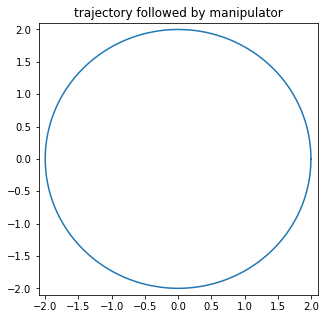

In [20]:
pos_actual=np.array(pos_actual)
plt.figure(figsize=(5,5))
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.title('trajectory followed by manipulator')
plt.plot(pos_actual[:,0],pos_actual[:,1])
#plt.plot(x1,x2)

In [21]:
pb.disconnect()